In [106]:
# Data Processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report,roc_auc_score,f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import collections
from collections import Counter
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, recall_score, precision_score, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler


import matplotlib.pyplot as plt
import seaborn as sns
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz

#### Import preprocessed data without missing values, removed outliers, and normalized

In [107]:

train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')


In [108]:
# Define the target variable (e.g., 'target') and features (all other columns)
X_train = train.drop('readmitted', axis=1)  # Drop the target column for features
y_train = train['readmitted']  # Select the target column

X_test = test.drop('readmitted', axis=1)  # Same for test set
y_test = test['readmitted']

#### Standard Bagging classifier for highly imbalanced data



In [109]:

# Create a bagging classifier 
bagging_clf = BaggingClassifier()

# Train the bagging classifier on the training data
bagging_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = bagging_clf.predict(X_test)

# Calculate the accuracy of the model
acc_bag = accuracy_score(y_test, y_pred)
print("Bagging Classifier - Test Accuracy:", round(acc_bag, 2))
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score is {0:.2f}".format(f1_score(y_test, y_pred)))

Bagging Classifier - Test Accuracy: 0.89
Accuracy is 0.89
Precision is 0.35
Recall is 0.04
F1 score is 0.07


#### Bagging With Random Undersampling (deacreasing the size of majority set)

In [110]:
# Apply random undersampling to the training set
print("Class distribution before undersampling:", Counter(y_train))
rus = RandomUnderSampler()
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print("Class distribution after undersampling:", Counter(y_train_resampled))

# Create a bagging classifier with random undersampling
bagging_classifier = BaggingClassifier()

# Train the bagging classifier on the resampled training data
bagging_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = bagging_classifier.predict(X_test)

# Calculate the accuracy of the model
acc_rndm = accuracy_score(y_test, y_pred)

print("Bagging Classifier with Random Undersampling - Test Accuracy:", round(acc_rndm, 2))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score is {0:.2f}".format(f1_score(y_test, y_pred)))


Class distribution before undersampling: Counter({0: 71155, 1: 9037})
Class distribution after undersampling: Counter({0: 9037, 1: 9037})
Bagging Classifier with Random Undersampling - Test Accuracy: 0.65
Accuracy is 0.65
Precision is 0.16
Recall is 0.49
F1 score is 0.24


#### Standard Random Forest Classifier 

In [111]:
# Create a Random Forest classifier 
rf = RandomForestClassifier(n_estimators=100)

# Train the Random Forest classifier on the training data
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)

# Calculate the accuracy of the model
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Standard Random Forest Accuracy:",round(acc_rf, 2))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred_rf)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred_rf)))
print("F1 score is {0:.2f}".format(f1_score(y_test, y_pred_rf)))


Standard Random Forest Accuracy: 0.89
Accuracy is 0.89
Precision is 0.38
Recall is 0.01
F1 score is 0.01


In [112]:
# Create a Random Forest Classifier with Class Weighting
rf_cw = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the Random Forest classifier on the training data
rf_cw.fit(X_train, y_train)

# Make predictions on the test set
y_pred_cw = rf_cw.predict(X_test)

# Calculate the accuracy of the model
acc_cw = accuracy_score(y_test, y_pred_cw)
print("Random Forest with Class Weighting Accuracy:",round(acc_cw, 2))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred_cw)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred_cw)))
print("F1 score is {0:.2f}".format(f1_score(y_test, y_pred_cw)))


Random Forest with Class Weighting Accuracy: 0.89
Precision is 0.68
Recall is 0.01
F1 score is 0.01


#### Random Forest with Random Undersampling

In [113]:
# Apply random undersampling to the training set
print("Class distribution before undersampling:", Counter(y_train))
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print("Class distribution after undersampling:", Counter(y_train_resampled))
# Create a Random Forest classifier with random undersampling
rf_rus = RandomForestClassifier(random_state=42)

# Train the Random Forest classifier on the resampled training data
rf_rus.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_rus = rf_rus.predict(X_test)

# Calculate the accuracy of the model
acc_rus = accuracy_score(y_test, y_pred_rus)
print("Random Forest with Random Undersampling Accuracy:",round(acc_rus,2))
print("Precision is {0:.2f}".format(precision_score(y_test, y_pred_rus)))
print("Recall is {0:.2f}".format(recall_score(y_test, y_pred_rus)))
print("F1 score is {0:.2f}".format(f1_score(y_test, y_pred_rus)))

Class distribution before undersampling: Counter({0: 71155, 1: 9037})
Class distribution after undersampling: Counter({0: 9037, 1: 9037})
Random Forest with Random Undersampling Accuracy: 0.63
Precision is 0.17
Recall is 0.60
F1 score is 0.26


#### Evaluation of Random forest with undersampling

Only 17% of the patients flagged as high risk for readmission were actually readmitted. This suggests the model generates a high number of false positives.
Recall (0.60):

The model successfully identifies 60% of the actual readmissions, which is decent. However, missing the remaining 40% (false negatives) could still have serious implications.


In [115]:
# Evaluate the model

# Calculate and print the accuracy
acc_rus = accuracy_score(y_test, y_pred_rus)
print("Random Forest with Random Undersampling Accuracy: {:.2f}".format(acc_rus))

# Calculate precision, recall, and F1-score for binary classification (assuming labels 0 and 1)
precision = precision_score(y_test, y_pred_rus)
recall = recall_score(y_test, y_pred_rus)
f1 = f1_score(y_test, y_pred_rus)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

# Print the classification report for detailed metrics across all classes
report = classification_report(y_test, y_pred_rus)
print("\nClassification Report:\n", report)



Random Forest with Random Undersampling Accuracy: 0.63
Precision: 0.17
Recall: 0.60
F1 Score: 0.26

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.63      0.75     17836
           1       0.17      0.60      0.26      2213

    accuracy                           0.63     20049
   macro avg       0.55      0.62      0.51     20049
weighted avg       0.84      0.63      0.70     20049



Confusion Matrix:
 [[11271  6565]
 [  883  1330]]


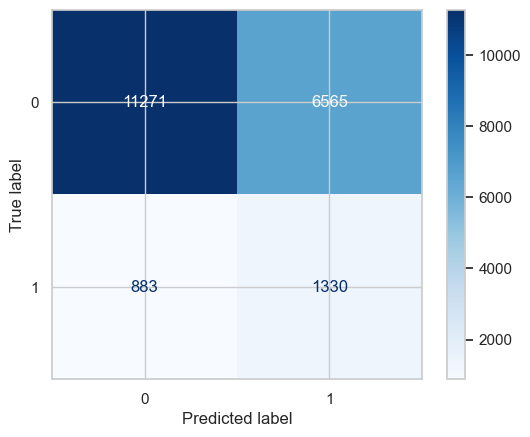

In [116]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_rus)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_rus.classes_)
disp.plot(cmap='Blues')

#### XGBoost Classifier with SMOTE + ENN oversampler

First, scale continious numerical values 

In [89]:

# Identify the binary and continuous columns

# List of continuous columns that you want to scale
continuous_columns = ['age', 'time_in_hospital','num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient_log',
       'number_emergency_log', 'number_inpatient_log']

# Separate the continuous features
X_train_continuous = X_train[continuous_columns]
X_test_continuous = X_test[continuous_columns]

# Apply StandardScaler to the continuous features
scaler = StandardScaler()
X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
X_test_continuous_scaled = scaler.fit_transform(X_test_continuous)


# Convert the scaled features back to a DataFrame
X_train_continuous_scaled = pd.DataFrame(X_train_continuous_scaled, columns=continuous_columns)
X_test_continuous_scaled = pd.DataFrame(X_test_continuous_scaled, columns=continuous_columns)

# Concatenate the scaled continuous columns with the rest of the data
X_train_scaled = pd.concat([X_train.drop(continuous_columns, axis=1), X_train_continuous_scaled], axis=1)
X_test_scaled = pd.concat([X_test.drop(continuous_columns, axis=1), X_test_continuous_scaled], axis=1)



##### Apply SMOTEENN to training data

In [90]:

counter = collections.Counter(y_train)
print('Before', counter)
# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample (X_train_scaled, y_train)
counter = collections.Counter (y_train_smenn)
print('After', counter)


Before Counter({0: 71155, 1: 9037})
After Counter({1: 70867, 0: 30038})


##### XGBoost classifier

Results With Oversampling Smote + ENN
XGBoost Accuracy: 0.47
Kappa Score: 0.07
F1 Score: 0.24
Recall: 0.76
Precision: 0.14


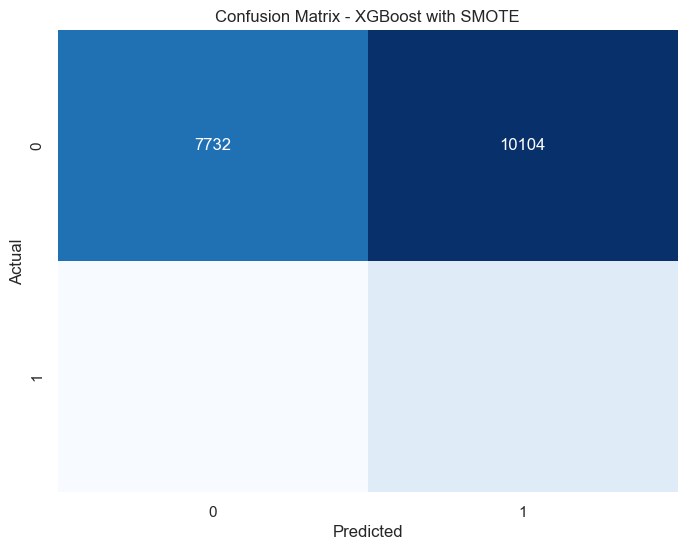

In [118]:

# Initialize and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(n_estimators=100, max_depth=10, n_jobs=-1, learning_rate=0.1, random_state=42)
xgb_classifier.fit(X_train_smenn, y_train_smenn)

# Make predictions using the model
y_pred = xgb_classifier.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print the evaluation metrics
print("Results With Oversampling Smote + ENN")
print("XGBoost Accuracy:", round(accuracy,2))
print("Kappa Score:", round(kappa,2))
print("F1 Score:", round(f1,2))
print("Recall:", round(recall,2))
print("Precision:", round(precision,2))

#print confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - XGBoost with SMOTE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Changing threshold 

Results With Oversampling Smote + ENN
XGBoost Accuracy: 0.54
Kappa Score: 0.08
F1 Score: 0.24
Recall: 0.68
Precision: 0.15


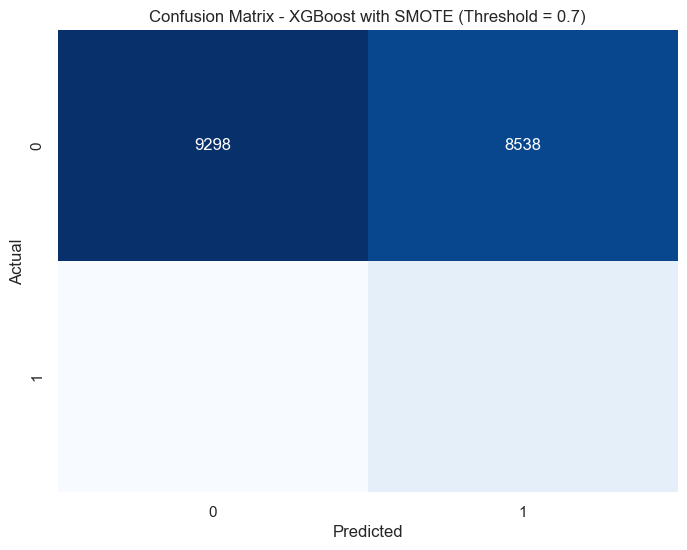

In [121]:
# Initialize and train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=10, 
    n_jobs=-1, 
    learning_rate=0.1, 
    random_state=42
)
xgb_classifier.fit(X_train_smenn, y_train_smenn)

# Get predicted probabilities for class 1
y_pred_proba = xgb_classifier.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

# Apply a threshold of 0.7
threshold = 0.6
y_pred_threshold = (y_pred_proba >= threshold).astype(int)

# Calculate evaluation metrics based on the new thresholded predictions
accuracy = accuracy_score(y_test, y_pred_threshold)
kappa = cohen_kappa_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)

# Print the evaluation metrics
print("Results With Oversampling Smote + ENN")
print("XGBoost Accuracy:", round(accuracy,2))
print("Kappa Score:", round(kappa,2))
print("F1 Score:", round(f1,2))
print("Recall:", round(recall,2))
print("Precision:", round(precision,2))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_threshold)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - XGBoost with SMOTE (Threshold = 0.7)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
